In [59]:
import pandas as pd
import numpy
import pylab

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score


%matplotlib inline  
import matplotlib.pyplot as plt


In [60]:
trainBodies = pd.read_csv('fncData/train_bodies.csv')
trainStances = pd.read_csv('fncData/train_stances.csv')
trainStancesRandom = pd.read_csv('fncData/train_stances.random.csv')
trainStances.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [80]:
unrelatedCount = trainStances[trainStances["Stance"] == "unrelated"].count()[0]
agreeCount = trainStances[trainStances["Stance"] == "agree"].count()[0]
disagreeCount = trainStances[trainStances["Stance"] == "disagree"].count()[0]
discussCount = trainStances[trainStances["Stance"] == "discuss"].count()[0]
totalCount = trainStances.count()[0]

print("Unrelated: ", float(unrelatedCount) / totalCount)
print("Disagree: ", float(disagreeCount) / totalCount)
print("Agree: ", float(agreeCount) / totalCount)
print("Discuss: ", float(discussCount) / totalCount)

('Unrelated: ', 0.7313095333386697)
('Disagree: ', 0.016809413271432)
('Agree: ', 0.07360121668134155)
('Discuss: ', 0.1782798367085568)


In [81]:
trainStancesRandom.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,discuss
1,Hundreds of Palestinians flee floods in Gaza a...,158,discuss
2,"Christian Bale passes on role of Steve Jobs, a...",137,disagree
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,disagree
4,Spider burrowed through tourist's stomach and ...,1923,agree


In [82]:
limit = len(trainStances)
limit = 1000
strip = True
lowercase = True

In [83]:
print "Train Stances (20/%s):" % (len(trainStances))
# trainStances.head(20)

trainStances["unrelated"] = trainStances["Stance"].apply(lambda x: 1 if x == "unrelated" else 0)
trainStances["agree"] = trainStances["Stance"].apply(lambda x: 1 if x == "agree" else 0)
trainStances["disagree"] = trainStances["Stance"].apply(lambda x: 1 if x == "disagree" else 0)
trainStances["discuss"] = trainStances["Stance"].apply(lambda x: 1 if x == "discuss" else 0)
trainStances["Body"] = [""] * len(trainStances)
for index, row in trainStances[0:limit].iterrows():
    trainStances.loc[index, "Body"] = trainBodies[trainBodies['Body ID'] == row["Body ID"]]['articleBody'].item()


import re
def preprocess(text, lowercase, strip):
    text = text.lower() if lowercase else text
    text = " ".join(re.findall("[a-zA-Z]+", text)) if strip else text
    return text

if strip or lowercase:
    trainStances["Body"]= trainStances["Body"].apply(lambda x: preprocess(x,lowercase,strip))
    trainStances["Headline"]= trainStances["Headline"].apply(lambda x: preprocess(x,lowercase,strip))
    

trainStances = trainStances.drop("Body ID", 1)
trainStances = trainStances.drop("Stance", 1)
    
trainStances.head()

Train Stances (20/49972):


,Headline,unrelated,agree,disagree,discuss,Body
0,police find mass graves with at least bodies n...,1,0,0,0,danny boyle is directing the untitled film set...
1,hundreds of palestinians flee floods in gaza a...,0,1,0,0,hundreds of palestinians were evacuated from t...
2,christian bale passes on role of steve jobs ac...,1,0,0,0,year old moscow resident was hospitalized with...
3,hbo and apple in talks for month apple tv stre...,1,0,0,0,reuters a canadian soldier was shot at the can...
4,spider burrowed through tourist s stomach and ...,0,0,1,0,fear not arachnophobes the story of bunbury s ...


In [84]:
print "Train Stances Random (20/%s)" % (len(trainStancesRandom))
# trainStancesRandom.head(20)

Train Stances Random (20/49972)


In [85]:
# build feature vocabulary
ngram = 1
vectorizer = CountVectorizer(ngram_range=(1, ngram))
trainStances["Number Of Common Words"] = [-1 for x in range(len(trainStances))]
trainStances["Number Of Words In Body"] = [-1 for x in range(len(trainStances))]
trainStances["Number Of Words In Headline"] = [-1 for x in range(len(trainStances))]

for index, row in trainStances[0:limit].iterrows():
    headline = row['Headline']
    body = row['Body']
    
#     print index
#     print "HEADLINE: \n%s\n" % headline
#     print "BODY: \n%s\n" % body

    headline_words = headline.split()
    body_words = body.split()
    
    num_words_in_common = len(set(headline_words).intersection(body_words))
    
    trainStances.loc[index, "Number Of Common Words"] = num_words_in_common  
    trainStances.loc[index, "Number Of Words In Body"] = len(body_words) 
    trainStances.loc[index, "Number Of Words In Headline"] = len(headline_words) 

trainStances.head()

# I'd like to graph the num_words_in_common integer to the stance classification, to see what kind of correlation we're working with here.

,Headline,unrelated,agree,disagree,discuss,Body,Number Of Common Words,Number Of Words In Body,Number Of Words In Headline
0,police find mass graves with at least bodies n...,1,0,0,0,danny boyle is directing the untitled film set...,2,198,17
1,hundreds of palestinians flee floods in gaza a...,0,1,0,0,hundreds of palestinians were evacuated from t...,10,429,11
2,christian bale passes on role of steve jobs ac...,1,0,0,0,year old moscow resident was hospitalized with...,4,187,17
3,hbo and apple in talks for month apple tv stre...,1,0,0,0,reuters a canadian soldier was shot at the can...,2,79,14
4,spider burrowed through tourist s stomach and ...,0,0,1,0,fear not arachnophobes the story of bunbury s ...,9,627,11


In [86]:
trainStances[0:limit].corr()

,unrelated,agree,disagree,discuss,Number Of Common Words,Number Of Words In Body,Number Of Words In Headline
unrelated,1.000000,-0.495683,-0.207277,-0.738470,-0.666706,-0.070439,0.006004
agree,-0.495683,1.000000,-0.041357,-0.147343,0.342553,0.008862,0.019269
disagree,-0.207277,-0.041357,1.000000,-0.061614,0.115451,-0.027733,-0.037013
discuss,-0.738470,-0.147343,-0.061614,1.000000,0.490998,0.085669,-0.008970
Number Of Common Words,-0.666706,0.342553,0.115451,0.490998,1.000000,0.238015,0.496067
Number Of Words In Body,-0.070439,0.008862,-0.027733,0.085669,0.238015,1.000000,0.038055
Number Of Words In Headline,0.006004,0.019269,-0.037013,-0.008970,0.496067,0.038055,1.000000


/Library/Python/2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


{'unrelated': 2.6227208976157081, 'disagree': 7.0, 'discuss': 7.572222222222222, 'agree': 7.7111111111111112}


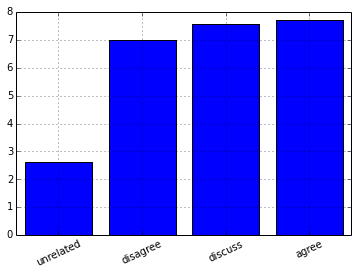

In [16]:
categoryNumberOfCommonWordsMeans = {
    "unrelated":0, "discuss":0, "agree":0, "disagree":0
}
for category in categoryNumberOfCommonWordsMeans: #for each category calculate the mean number of words in common between header and body 
    categoryNumberOfCommonWordsMeans[category] = trainStances[0:limit][trainStances[category] == 1].mean()["Number Of Common Words"]

print(categoryNumberOfCommonWordsMeans)

values = [] #in same order as traversing keys
keys = [] #also needed to preserve order
for key in categoryNumberOfCommonWordsMeans.keys():
  keys.append(key)

  values.append(categoryNumberOfCommonWordsMeans[key])
    
l = plt.bar(range(len(values)), values,align='center')
plt.xticks(range(len(keys)), keys, rotation=25)
plt.grid(True)



In [20]:
from sklearn.feature_extraction.text import CountVectorizer
bodies = [x for x in trainStances[0:limit]["Body"]]
headlines = [x for x in trainStances[0:limit]["Headline"]]

# could make count vectors for each type
cv=CountVectorizer()
# or tfidf vectorizer 
#cv=TfidfVectorizer()
cv.fit(bodies + headlines)
bodyBOWVectors = cv.transform(bodies)
headlineBOWVectors = cv.transform(headlines)

print("Size:", headlineBOWVectors.shape, "same" if bodyBOWVectors.shape==headlineBOWVectors.shape else "DIFFERENT!!!")

# maybe its better to have one vector where the presence of the word is scaled
# up if that word is present in the headline, otherwise scaled down 
# something of the form, but scaled with constants...
combinedVectors = bodyBOWVectors.multiply(headlineBOWVectors)


('Size:', (1000, 15064), 'same')


In [91]:
x_train = list([[x] for x in trainStances[0:limit]["Number Of Common Words"]])
y_train = list([y for y in trainStances[0:limit]["unrelated"]])

clf = LogisticRegression()
clf.fit(x_train, y_train)
scores = cross_val_score(clf, x_train, y_train, cv=5)
accuracy = scores.mean()
print "Crossvalidation", scores, ("Accuracy: %0.2f (+/- %0.2f)" % (accuracy, scores.std() * 2))
print("Coefficient for number of words is ", clf.coef_[0][0])



Crossvalidation [ 0.87562189  0.83084577  0.865       0.84422111  0.83417085] Accuracy: 0.85 (+/- 0.04)
('Coefficient for number of words is ', -0.64859411595685146)


In [54]:
lr = LinearRegression()

lr.fit(x_train, y_train)

#predictions = lr.predict(x_test)

#o = DictWriter(open("predictions.csv", 'w'), ["Id", "spoiler"])
#o.writeheader()
#for ii, pp in zip([x['Id'] for x in test], predictions):
#    d = {'Id': ii, 'spoiler': labels[pp]}
#    o.writerow(d)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)